# Project 5 - Pre-train and Fineturn Chemprop & Build Research Final Model #

## Import Libraries ##

In [1]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

import chemprop
from chemprop import data, featurizers, models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

# import necessary libraries for Chemberta model
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, AdamW, get_linear_schedule_with_warmup , BertModel

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

In [2]:
import math
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import warnings
from torch import Tensor
from torch.nn.utils.weight_norm import weight_norm
from typing import Optional
from typing import Tuple

In [3]:
def PRINT() -> None: print(f"{'-'*80}\nDone\n{'-'*80}")
def PRINTC() -> None: print(f"{'-'*80}")
def PRINTM(M) -> None: print(f"{'-'*80}\n{M}\n{'-'*80}")

## Verify GPU Availability ##

In [4]:
!nvidia-smi

Fri Sep  6 09:35:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:21:00.0 Off |                  Off |
| 30%   32C    P8             23W /  300W |       1MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

For this task, we'll use the BGU cluster GPU `NVIDIA RTX 6000 Ada Generation` to achieve better performance during the training of our pre-trained and fine-tuned models, allowing for more efficient processing of large datasets and complex computations.

In [5]:
if torch.cuda.is_available():
    PRINTM(f"GPU is available.")
    device = "cuda"
else:
    PRINTM(f"GPU is not available. Using CPU instead.")
    device = "cpu"

--------------------------------------------------------------------------------
GPU is available.
--------------------------------------------------------------------------------


In [6]:
PRINTM(f"PyTorch version: {torch.__version__}")
PRINTM(f"CUDA available: {torch.cuda.is_available()}")
PRINTM(f"CUDA version:  {torch.version.cuda}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No CUDA'}")

--------------------------------------------------------------------------------
PyTorch version: 2.3.1+cu121
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
CUDA available: True
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
CUDA version:  12.1
--------------------------------------------------------------------------------
CUDA device: NVIDIA RTX 6000 Ada Generation


## Pre-train & Fineturne Chemprop ##

In [6]:
pt_dataset = pd.read_csv(os.path.join('datasets', 'pt_dataset_r4_scaled.csv'))
PRINTM('Loaded the dataset successfully !')

--------------------------------------------------------------------------------
Loaded the dataset successfully !
--------------------------------------------------------------------------------


In [20]:
pt_dataset.shape

(40640, 1203)

In [25]:
pt_dataset

,SMILES,NumAtomStereoCenters,NumAmideBonds,MolWt,NumValenceElectrons,TPSA,MolLogP,NumHeteroatoms,NumRotatableBonds,HeavyAtomCount,...,MorganFP_1014,MorganFP_1015,MorganFP_1016,MorganFP_1017,MorganFP_1018,MorganFP_1019,MorganFP_1020,MorganFP_1021,MorganFP_1022,MorganFP_1023
0,O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1,0.275373,-1.282846,-0.845008,-0.596023,-0.161562,-2.262849,-0.537115,1.030310,-0.672558,...,1,0,0,0,0,0,0,0,0,0
1,COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1,2.681296,-0.284266,-0.324957,-0.044627,0.165315,-0.451147,0.148945,-0.852020,-0.099286,...,0,0,0,0,0,1,0,0,0,0
2,Cc1noc(C2COCCN2C(=O)c2cscc2C)n1,0.275373,-0.284266,-1.284840,-1.478255,-0.110322,-1.000551,0.148945,-1.479464,-1.532466,...,0,0,0,0,0,1,0,0,0,1
3,CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC,0.275373,-0.284266,-0.383708,-0.265185,-0.744641,-0.997752,-0.537115,1.030310,-0.672558,...,0,0,0,0,0,0,0,0,0,1
4,CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1,0.275373,-0.284266,0.253544,0.396489,1.396847,0.816683,0.835004,-0.224577,0.473986,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40635,CC(C)(CNC(=N)N)N1CCc2ccccc2C1.I,-0.927589,-1.282846,0.331146,-1.478255,-0.305859,-1.041303,-1.223175,-0.852020,-1.819103,...,0,0,0,0,0,0,0,0,0,0
40636,Cc1ccc(C2=NN(C(=O)c3cccnc3)C(c3ccc(F)cc3)C2)cc...,0.275373,-0.284266,0.762391,0.506768,-1.459059,2.258719,-0.537115,-0.852020,0.760623,...,0,0,0,0,0,1,0,0,0,0
40637,CCOc1cccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CC2CC...,1.478335,-0.284266,1.233995,1.499280,1.021674,1.124593,0.148945,1.030310,1.620531,...,0,0,0,0,0,1,0,0,0,1
40638,CCn1cc(C2CSCCN2)cn1.Cl.Cl,0.275373,-1.282846,-1.746518,-2.470767,-2.384327,-0.822913,-0.537115,-1.479464,-2.965647,...,0,0,0,0,0,1,0,0,0,0


## Visualization ##

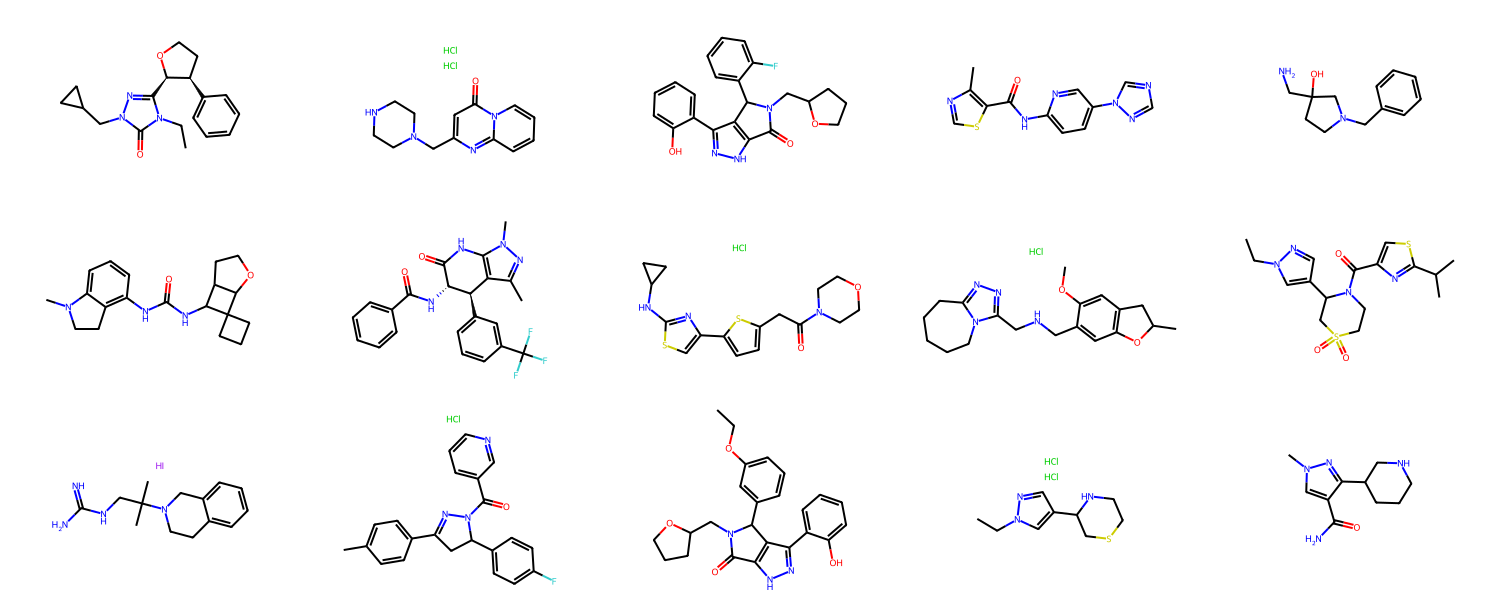

In [7]:
sample_smiles = pt_dataset['SMILES'].tail(15)
molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]

# Visualize the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300, 200))
img

## Pre Train Multi-Regression Model using Chemprop V2 ##

### Hyperparameter Search ####

In [ ]:
!chemprop hpopt --data-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/datasets/pt_dataset_r4_scaled.csv" \
    --task-type regression \
    --search-parameter-keywords basic\
    --split-sizes 0.8 0.1 0.1 \
    --raytune-num-samples 8 \
    --raytune-use-gpu \
    --hpopt-save-dir hyperparam_dir_r4

In [ ]:
!chemprop train --data-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/datasets/pt_dataset_r4_scaled.csv" \
    --config-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/hyperparam_dir/best_config.toml" \
    --output-dir pt_chemprop_checkpoint_r4_

In [ ]:
!chemprop train --data-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/datasets/pt_dataset_final_scaled.csv" \
    --config-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/hyperparam_dir/best_config.toml" \
    --output-dir pt_chemprop_checkpoint

In [ ]:
!chemprop train --data-path "/sise/home/gavrilev/DLResearchPPI/Project 5 PT, FT & more/datasets/pt_dataset_final_scaled.csv" \
--task-type regression \
--output-dir pt_v2_checkpoint \
--split-sizes 0.8 0.1 0.1 \
--num-folds 5 \
--epochs 75 \
--num-workers 5

In order to keep the code readable, we cleaned the output of the pre-train phase.

Entire Test Set results: {'entire_test/mse': 0.030957844183649132}

# Fine Tune Chemprop Pre-trained Model & Generate AUVG_PPI Model #

### Load ESM Protein Features Datasetm ###

In [7]:
ppi_features_df = pd.read_csv(os.path.join('datasets', 'merged_ppi_features.csv'))
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [8]:
ppi_features_df.head()

,UniProt_ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_6549,Feature_6550,Feature_6551,Feature_6552,Feature_6553,Feature_6554,Feature_6555,Feature_6556,Feature_6557,Feature_6558
0,P14174,-0.193412,-1.059180,-1.278588,-0.263681,-0.386063,-0.915209,-0.668021,0.093001,0.177767,...,-0.638152,-0.473444,0.745981,-0.451562,-2.777358,-1.538830,0.639083,-2.094676,0.286921,2.930260
1,P37231,0.265186,-0.030587,-0.290296,-0.760123,-0.629531,-0.424159,-0.639366,-0.677950,-0.026118,...,2.327607,0.024786,0.870385,-0.229874,-0.297020,1.548407,0.651663,-0.201770,-0.571092,-0.550890
2,Q16695,-0.457738,-0.578066,-1.078967,-0.380653,-0.529394,0.342126,3.185610,0.819713,-0.407514,...,-1.060836,-0.302551,1.048564,0.980907,-0.509805,0.867835,0.441861,1.236238,-1.328273,-1.193699
3,Q86Y26,-0.302110,-0.103794,0.235311,0.308580,-0.420244,0.325662,0.747183,1.307642,1.054643,...,-0.348597,2.332675,-1.435320,-0.685403,-0.299964,0.996614,-0.941635,0.747357,2.159298,-1.118946
4,Q14469,1.493006,0.636802,-0.305837,1.480889,0.848687,-0.507851,0.909075,1.592308,1.030355,...,0.658024,1.259431,1.463462,0.111468,1.053912,-0.894036,-0.583210,-0.825652,0.860949,-1.388991


In [9]:
PRINTM(f'ESM features dataset shape -> {ppi_features_df.shape}')

--------------------------------------------------------------------------------
ESM features dataset shape -> (304, 6559)
--------------------------------------------------------------------------------


In [16]:
n = ppi_features_df[['UniProt_ID']].nunique()
PRINTM(f'Number of unique PPI: {n}')

--------------------------------------------------------------------------------
Number of unique PPI: UniProt_ID    292
dtype: int64
--------------------------------------------------------------------------------


### Load Final Dataset ###

In [17]:
final_df = pd.read_csv(os.path.join('datasets', 'final_dataset_2_0.75.csv'))
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [18]:
final_df.head()

,smiles,uniprot_id1,uniprot_id2,label
0,OC(=O)c1nc(sc1-c1ccc(cc1)-c1ccccc1)-c1ccc2CCCN...,P08514,P05106,0
1,CN1C(=O)N(c2cc(Cl)cc(Cl)c2)C(=O)[C@]12CN(c1nc3...,P04637,O15151,0
2,CC(C)NS(=O)(=O)c1ccc(OCC(=O)N2CCOCC2)cc1,P13612,P05556,0
3,CC(=O)N1CCN(C(=O)/C=C/c2ccc(Sc3ccccc3C(N)=O)c(...,P05362,P20701,1
4,CC(C)C1=C(SC2=N[C@](C)([C@H](N12)c1ccc(Cl)cc1)...,Q00987,P04637,1


In [19]:
PRINTM(f'Final dataset shape -> {final_df.shape}')

--------------------------------------------------------------------------------
Final dataset shape -> (109248, 4)
--------------------------------------------------------------------------------


### Fix Datasets ###

In [6]:
uniprot_mapping = pd.read_csv(os.path.join('datasets', 'idmapping_unip.tsv'), delimiter = "\t")
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


## Finetune Step ##

In [7]:
def convert_uniprot_ids(dataset, mapping_df):
    # Create a dictionary from the mapping dataframe
    mapping_dict = mapping_df.set_index('From')['Entry'].to_dict()

    # Map the uniprot_id1 and uniprot_id2 columns to their respective Entry values
    dataset['uniprot_id1'] = dataset['uniprot_id1'].map(mapping_dict)
    dataset['uniprot_id2'] = dataset['uniprot_id2'].map(mapping_dict)
    return dataset.drop_duplicates()

In [8]:
class PretrainedChempropModel(nn.Module):
    def __init__(self, checkpoints_path, batch_size):
        super(PretrainedChempropModel, self).__init__()
        self.mpnn = self.load_pretrained_model(checkpoints_path)
        self.featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        self.batch_size = batch_size
        
    def forward(self, smiles):
        # Prepare the data in order to generate embeddings from modulators SMILES
        self.smiles_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smiles]
        self.smiles_dset = data.MoleculeDataset(self.smiles_data, featurizer=self.featurizer)
        self.smiles_loader = data.build_dataloader(self.smiles_dset, batch_size=batch_size, shuffle=False)
        
        embeddings = [
            # Etract the embedding from the last FFN layer, i.e., before the final prediction(thus i=-1)
            self.mpnn.predictor.encode(self.fingerprints_from_batch_molecular_graph(batch, self.mpnn), i=-1) 
            for batch in self.smiles_loader
        ]
        #print(embeddings)
        if not embeddings:
             return torch.empty(0, device=device)
        embeddings = torch.cat(embeddings, 0).to(device)
        return embeddings

    def fingerprints_from_batch_molecular_graph(self, batch, mpnn):
        batch.bmg.to(device)
        H_v = mpnn.message_passing(batch.bmg, batch.V_d)
        H = mpnn.agg(H_v, batch.bmg.batch)
        H = mpnn.bn(H)
        fingerprints = H if batch.X_d is None else torch.cat((H, mpnn.batch.X_d_transform(X_d)), 1)
        return fingerprints

    def load_pretrained_model(self, checkpoints_path):
        mpnn = models.MPNN.load_from_checkpoint(checkpoints_path).to(device)
        return mpnn

In [9]:
class ChemBERTaPT(nn.Module):
    def __init__(self):
        super(ChemBERTaPT, self).__init__()
        self.model_name = "DeepChem/ChemBERTa-77M-MTR"
        self.chemberta = RobertaModel.from_pretrained(self.model_name)

    def forward(self, input_ids, attention_mask):
        bert_output = self.chemberta(input_ids=input_ids, attention_mask=attention_mask)
        return bert_output[1]

In [10]:
class custom_self_attention(nn.Module):
    def __init__(self, embed_dim_, num_heads_, dropout_):
        super(custom_self_attention, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim_, num_heads=num_heads_, dropout= dropout_)
        self.norm_layer = nn.LayerNorm(embed_dim_)

    def forward(self, embeddings_mat):
        # Apply self-attention for PPI
        embeddings_mat = embeddings_mat.permute(1, 0, 2)  # Change to (num_heads, batch_size, embed_dim) for MultiheadAttention
        attn_output, attn_weights = self.self_attention(embeddings_mat, embeddings_mat, embeddings_mat)
        attn_output = attn_output.permute(1, 0, 2)  # shape ->> (batch_size, num_heads, embed_dim)

        # Add & Norm
        embeddings_mat = embeddings_mat.permute(1, 0, 2)  # Back to original shape for residual connection
        attn_output = (0.5*attn_output) + (0.5*embeddings_mat)  # Add (residual connection) & apply weighted residual connection 
        attn_output = self.norm_layer(attn_output)  # Apply LayerNorm

        # Flatten the output for the next MLP layer
        embeddings_mat = attn_output.flatten(start_dim=1)  # Shape: (batch_size, num_heads*embed_dim)
        
        return embeddings_mat

In [26]:
# With Attention 
class AUVG_PPI(nn.Module):
    def __init__(self, pretrained_chemprop_model, chemberta_model, dropout):
        
        super(AUVG_PPI, self).__init__()
        self.pretrained_chemprop_model = pretrained_chemprop_model
        self.chemberta_model = chemberta_model
        self.dropout = dropout
        self.ppi_self_attention = custom_self_attention(512, 8, 0.2)
        self.smiles_self_attention = custom_self_attention(128, 4, 0.2)
        self.cross_attention = nn.MultiheadAttention(512, 8, 0.2)
        self.max_pool = nn.MaxPool1d(2)
        
        # PPI Features MLP layers: (esm, custom, fegs, gae)
        self.esm_mlp = nn.Sequential(
            nn.Linear(in_features=1280 + 1280 , out_features=1750),
            nn.ReLU(),
            nn.BatchNorm1d(1750),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1750, out_features=1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1000, out_features=750),
            nn.ReLU(),
            nn.BatchNorm1d(750),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=750, out_features=512)
        )

        self.fegs_mlp = nn.Sequential(
            nn.Linear(in_features=578 + 578, out_features=750),
            nn.ReLU(),
            nn.BatchNorm1d(750),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=750, out_features=512)
        )        

        self.custom_mlp = nn.Sequential(
            nn.Linear(in_features=4700 + 4700 , out_features=8000),
            nn.ReLU(),
            nn.BatchNorm1d(8000),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=8000, out_features=6500),
            nn.ReLU(),
            nn.BatchNorm1d(6500),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=6500, out_features=5000),
            nn.ReLU(),
            nn.BatchNorm1d(5000),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=5000, out_features=3500),
            nn.ReLU(),
            nn.BatchNorm1d(3500),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=3500, out_features=2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=2000, out_features=1028),
            nn.ReLU(),
            nn.BatchNorm1d(1028),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1028, out_features=512)
        )

        self.gae_mlp = nn.Sequential(
            nn.Linear(in_features=500 + 500, out_features=750),
            nn.ReLU(),
            nn.BatchNorm1d(750),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=750, out_features=512)
        )

        # MLP for ppi_features
        self.ppi_mlp = nn.Sequential(
            nn.Linear(in_features=512 * 4 , out_features= 1536),
            nn.ReLU(),
            nn.BatchNorm1d(1536),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=512)
        )
        
        self.fp_mlp = nn.Sequential(
            nn.Linear(in_features=2100, out_features=1536),
            nn.ReLU(),
            nn.BatchNorm1d(1536),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1536, out_features=1024), 
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128)
        )

        self.mfp_mlp = nn.Sequential(
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128)
        )

        self.chemberta_mlp = nn.Sequential(
            nn.Linear(in_features = 384, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128)
        )

        self.chem_descriptors_mlp = nn.Sequential(
            nn.Linear(in_features = 194, out_features=128)
        )

        # Additional layrs in order to concatinate chemprop fingerprints, chemBERTa embeddings & ppi features all together
        self.additional_layers = nn.Sequential(
            nn.Linear(in_features=256 + 256, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=64, out_features=1)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, bmg, esm, custom, fegs, gae,
                input_ids, attention_mask,
                morgan_fingerprints, chemical_descriptors):
        # Forward pass batch mol graph through pretrained chemprop model in order to get fingerprints embeddings
        # Afterwards, pass the fingerprints through MLP layer
        cp_fingerprints = self.pretrained_chemprop_model(bmg)
        cp_fingerprints = self.fp_mlp(cp_fingerprints)

        chemberta_embeddings = self.chemberta_model(input_ids, attention_mask)
        chemberta_embeddings = self.chemberta_mlp(chemberta_embeddings)
        mfp = self.mfp_mlp(morgan_fingerprints)
        chemical_descriptors = self.chem_descriptors_mlp(chemical_descriptors)
        
        # Concatenate all 4 smiles embeddings along a new dimension (4x194) & pass them throw self-attention layer
        smiles_embeddings = torch.stack([cp_fingerprints,chemberta_embeddings, mfp, chemical_descriptors], dim=1).to(device)  # shape ->> (batch_size, 4, 194)
        smiles_features = self.smiles_self_attention(smiles_embeddings)
        smiles_embeddings = smiles_features.unsqueeze(1)

        # Pass all PPI features  through MLP layers, and then pass them all together into another MLP layer
        #ppi_features = proteins.to(device)
        esm_embeddings = self.esm_mlp(esm)
        custom_embeddings = self.custom_mlp(custom)
        fegs_embeddings = self.fegs_mlp(fegs)
        gae_embeddings = self.gae_mlp(gae)

        # Concatenate all 4 ppi embeddings along a new dimension (4x320) & pass them throw self-attention layer
        ppi_embeddings = torch.stack([esm_embeddings, custom_embeddings, fegs_embeddings, gae_embeddings], dim=1).to(device)  # shape ->> (batch_size, 4, 320)
        ppi_features = self.ppi_self_attention(ppi_embeddings)
        ppi_features = self.ppi_mlp(ppi_features).unsqueeze(1)

        #Cross-attention between smiles and PPI to capture the interaction relationships
        ppi_QKV = ppi_features.permute(1, 0, 2)
        smiles_QKV = smiles_embeddings.permute(1, 0, 2)
        
        smiles_att, _ = self.cross_attention(smiles_QKV, ppi_QKV, ppi_QKV)
        ppi_att, _ = self.cross_attention(ppi_QKV, smiles_QKV, smiles_QKV)

        # permute attention outputrs to match (batch_size, embed_dim, num_heads) shape
        smiles_attn_output = (0.5* smiles_att.permute(1, 2, 0)) + (0.5* smiles_embeddings.permute(0, 2, 1))  # Add (residual connection) & apply weighted residual connection 
        ppi_attn_output = (0.5* ppi_att.permute(1, 2, 0)) + (0.5* ppi_features.permute(0, 2, 1))  # Add (residual connection) & apply weighted residual connection 

        # Drop the last dim in order to get (batch_size, embed_dim) & 
        # Pass cross-attention norm outputs throw max-pool layer before passing throw MLP layers
        smiles_att = self.max_pool(smiles_attn_output.squeeze(2))
        ppi_att = self.max_pool(ppi_attn_output.squeeze(2)) 
        combined_embeddings = torch.cat([smiles_att, ppi_att], dim=1)
        output = self.additional_layers(combined_embeddings)
        
        return self.sigmoid(output)

    def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device):
        PRINTM(f'Start training !')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            running_loss = 0.0
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in train_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)

                
                optimizer.zero_grad()
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas,batch_morgan, batch_chem_desc)

                loss = criterion(outputs.squeeze(), batch_labels)    
                loss.backward()
                optimizer.step()
    
            # Validate the model on the validation set
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            end_time = time.time()
            epoch_time = (end_time - start_time) / 60
            PRINTC()
            print(f"Epoch: {epoch+1}")
            print(f"Validation BCELoss: {val_loss:.5f}")
            print(f"Validation Accuracy (>0.8): {val_accuracy:.2f}")
            print(f"Validation AUC: {val_auc:.5f}")
            print(f"Epoch time: {epoch_time:.2f} minutes")
            PRINTC()
    
        print("Finish training !")

    def test_model(self, test_dataset, criterion, batch_size, shuffle, device):
        test_dataset = MoleculeDataset(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
        self.eval()
        
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        
        # Initialize prob_df
        prob_df = pd.DataFrame(columns=['uniprot_id1', 'uniprot_id2', 'output_prob', 'label'])
        
        with torch.no_grad():
            for (batch_smiles, batch_uniprots_tuple, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in test_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features, batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)
    
                loss = criterion(outputs.squeeze(), batch_labels)
                test_loss += loss.item()
        
                # Get the output probabilities and labels
                output_probs = outputs.squeeze().cpu().numpy()
                labels = batch_labels.cpu().numpy()
        
                # Add to prob_df
                for i in range(len(batch_uniprots_tuple)):
                    uniprot_id1, uniprot_id2 = batch_uniprots_tuple[i][0], batch_uniprots_tuple[i][1]
                    prob_df = prob_df.append({
                        'uniprot_id1': uniprot_id1,
                        'uniprot_id2': uniprot_id2,
                        'output_prob': output_probs[i],
                        'label': labels[i]
                    }, ignore_index=True)
        
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        # calc average probabilities for duplicate UniProt ID pairs (ensures only one pair is taken into consideration)
        prob_df['pair'] = prob_df.apply(lambda row: tuple(sorted([row['uniprot_id1'], row['uniprot_id2']])), axis=1)
        avg_prob_df = prob_df.groupby('pair').agg({'output_prob': 'mean', 'label': 'first'}).reset_index()
    
        # extract final all_labels and all_outputs
        all_labels = avg_prob_df['label'].tolist()
        all_outputs = avg_prob_df['output_prob'].tolist()
    
        test_loss /= len(test_loader)
        accuracy = correct / total
        test_auc = roc_auc_score(all_labels, all_outputs)
        
        print(f"Test BCELoss: {test_loss:.5f}")
        print(f"Test Accuracy: {accuracy:.2f}")
        print(f"Test AUC: {test_auc:.5f}")
    
        return prob_df, test_auc

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc ,batch_labels) in val_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)
                loss = criterion(outputs.squeeze(), batch_labels)
                val_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_auc = roc_auc_score(all_labels, all_outputs)  
        return val_loss, accuracy, val_auc

    def cross_validate(self, dataset, num_folds=5,num_epochs=10, batch_size=32, learning_rate=0.0001, weight_decay=1e-5, shuffle=True, device='cuda'):
        kf = KFold(n_splits=num_folds, shuffle=shuffle)
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print(f"Fold {fold+1}/{num_folds}")
            
            # Split dataset
            train_subset = dataset.iloc[train_idx].reset_index(drop=True)
            val_subset = dataset.iloc[val_idx].reset_index(drop=True)
            
            train_dataset = MoleculeDataset(train_subset)
            val_dataset = MoleculeDataset(val_subset)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            self.train_model(num_epochs, train_loader, val_loader, optimizer, criterion, device)
            
            # Validate the model
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            fold_results.append((val_loss, val_accuracy, val_auc))

            PRINTC()
            print(f"Fold {fold+1} - Validation BCELoss: {val_loss:.5f}, Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.5f}")
            PRINTC()
            
        avg_val_loss = sum([result[0] for result in fold_results]) / num_folds
        avg_val_accuracy = sum([result[1] for result in fold_results]) / num_folds
        avg_val_auc = sum([result[2] for result in fold_results]) / num_folds
        
        print(f"\nAverage Validation BCELoss: {avg_val_loss:.5f}")
        print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"Average Validation AUC: {avg_val_auc:.5f}")
        
        return fold_results

In [36]:
# With Attention 
class AUVG_PPI(nn.Module):
    def __init__(self, pretrained_chemprop_model, chemberta_model, dropout):
        super(AUVG_PPI, self).__init__()
        self.pretrained_chemprop_model = pretrained_chemprop_model
        self.chemberta_model = chemberta_model
        self.dropout = dropout
        
        self.ppi_self_attention = custom_self_attention(320, 4, 0.2)
        self.smiles_self_attention = custom_self_attention(192, 2, 0.2)
        self.cross_attention = nn.MultiheadAttention(128, 2, 0.2)
        self.norm_layer = nn.LayerNorm(128)
        self.max_pool = nn.MaxPool1d(2)
        
        # PPI Features MLP layers: (esm, custom, fegs, gae)
        self.esm_mlp = nn.Sequential(
            nn.Linear(in_features=1280 + 1280 , out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320)
        )

        self.fegs_mlp = nn.Sequential(
            nn.Linear(in_features=578 + 578, out_features=578),
            nn.ReLU(),
            nn.BatchNorm1d(578),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=578, out_features=320)
        )        

        self.custom_mlp = nn.Sequential(
            nn.Linear(in_features=4700 + 4700 , out_features=4700),
            nn.ReLU(),
            nn.BatchNorm1d(4700),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=4700, out_features=2560),
            nn.ReLU(),
            nn.BatchNorm1d(2560),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=2560, out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320), 
        )

        self.gae_mlp = nn.Sequential(
            nn.Linear(in_features=500 + 500, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=320)
        )

        # MLP for ppi_features
        self.ppi_mlp = nn.Sequential(
            nn.Linear(in_features=320 + 320 + 320 + 320 , out_features=480),
            nn.ReLU(),
            nn.BatchNorm1d(480),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=480, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128)
        )
        
        self.fp_mlp = nn.Sequential(
            nn.Linear(in_features=2100, out_features=1050),
            nn.ReLU(),
            nn.BatchNorm1d(1050),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1050, out_features=600), 
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=600, out_features=192)
        )

        self.mfp_mlp = nn.Sequential(
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=192)
        )

        self.chemberta_mlp = nn.Sequential(
            nn.Linear(in_features = 384, out_features=192)
        )

        self.chem_descriptors_mlp = nn.Sequential(
            nn.Linear(in_features = 194, out_features=192)
        )
        self.smiles_mlp = nn.Sequential(
            nn.Linear(in_features=192 + 192 + 192 + 192, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128)
        )

        # Additional layrs in order to concatinate chemprop fingerprints, chemBERTa embeddings & ppi features all together
        self.additional_layers = nn.Sequential(
            nn.Linear(in_features=64 + 64, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=32, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, bmg, esm, custom, fegs, gae,
                input_ids, attention_mask,
                morgan_fingerprints, chemical_descriptors):
        # Forward pass batch mol graph through pretrained chemprop model in order to get fingerprints embeddings
        # Afterwards, pass the fingerprints through MLP layer
        cp_fingerprints = self.pretrained_chemprop_model(bmg)
        cp_fingerprints = self.fp_mlp(cp_fingerprints)

        chemberta_embeddings = self.chemberta_model(input_ids, attention_mask)
        chemberta_embeddings = self.chemberta_mlp(chemberta_embeddings)
        mfp = self.mfp_mlp(morgan_fingerprints)
        chemical_descriptors = self.chem_descriptors_mlp(chemical_descriptors)
        
        # Concatenate all 4 smiles embeddings along a new dimension (4x194) & pass them throw self-attention layer
        smiles_embeddings = torch.stack([cp_fingerprints,chemberta_embeddings, mfp, chemical_descriptors], dim=1).to(device)  # shape ->> (batch_size, 4, 194)
        smiles_features = self.smiles_self_attention(smiles_embeddings)
        smiles_embeddings = self.smiles_mlp(smiles_features).unsqueeze(1)

        # Pass all PPI features  through MLP layers, and then pass them all together into another MLP layer
        #ppi_features = proteins.to(device)
        esm_embeddings = self.esm_mlp(esm)
        custom_embeddings = self.custom_mlp(custom)
        fegs_embeddings = self.fegs_mlp(fegs)
        gae_embeddings = self.gae_mlp(gae)

        # Concatenate all 4 ppi embeddings along a new dimension (4x320) & pass them throw self-attention layer
        ppi_embeddings = torch.stack([esm_embeddings, custom_embeddings, fegs_embeddings, gae_embeddings], dim=1).to(device)  # shape ->> (batch_size, 4, 320)
        ppi_features = self.ppi_self_attention(ppi_embeddings)
        ppi_features = self.ppi_mlp(ppi_features).unsqueeze(1)

        #Cross-attention between smiles and PPI to capture the interaction relationships
        ppi_QKV = ppi_features.permute(1, 0, 2)
        smiles_QKV = smiles_embeddings.permute(1, 0, 2)
        
        smiles_att, _ = self.cross_attention(smiles_QKV, ppi_QKV, ppi_QKV)
        ppi_att, _ = self.cross_attention(ppi_QKV, smiles_QKV, smiles_QKV)

        # permute attention outputrs to match (batch_size, embed_dim, num_heads) shape
        smiles_attn_output = (0.5* smiles_att.permute(1, 2, 0)) + (0.5* smiles_embeddings.permute(0, 2, 1))  # Add (residual connection) & apply weighted residual connection 
        ppi_attn_output = (0.5* ppi_att.permute(1, 2, 0)) + (0.5* ppi_features.permute(0, 2, 1))  # Add (residual connection) & apply weighted residual connection 

        # Drop the last dim in order to get (batch_size, embed_dim) & 
        # Pass cross-attention norm outputs throw max-pool layer before passing throw MLP layers
        smiles_att = self.max_pool(smiles_attn_output.squeeze(2))
        ppi_att = self.max_pool(ppi_attn_output.squeeze(2)) 
        combined_embeddings = torch.cat([smiles_att, ppi_att], dim=1)
        output = self.additional_layers(combined_embeddings)
        
        return self.sigmoid(output)

    def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device):
        PRINTM(f'Start training !')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            running_loss = 0.0
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in train_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)

                
                optimizer.zero_grad()
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas,batch_morgan, batch_chem_desc)

                loss = criterion(outputs.squeeze(), batch_labels)    
                loss.backward()
                optimizer.step()
    
            # Validate the model on the validation set
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            end_time = time.time()
            epoch_time = (end_time - start_time) / 60
            PRINTC()
            print(f"Epoch: {epoch+1}")
            print(f"Validation BCELoss: {val_loss:.5f}")
            print(f"Validation Accuracy (>0.8): {val_accuracy:.2f}")
            print(f"Validation AUC: {val_auc:.5f}")
            print(f"Epoch time: {epoch_time:.2f} minutes")
            PRINTC()
    
        print("Finish training !")

    def test_model(self, test_dataset, criterion, batch_size, shuffle, device):
        test_dataset = MoleculeDataset(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
        self.eval()
        
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        
        # Initialize prob_df
        prob_df = pd.DataFrame(columns=['uniprot_id1', 'uniprot_id2', 'output_prob', 'label'])
        
        with torch.no_grad():
            for (batch_smiles, batch_uniprots_tuple, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in test_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features, batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)
    
                loss = criterion(outputs.squeeze(), batch_labels)
                test_loss += loss.item()
        
                # Get the output probabilities and labels
                output_probs = outputs.squeeze().cpu().numpy()
                labels = batch_labels.cpu().numpy()
        
                # Add to prob_df
                for i in range(len(batch_uniprots_tuple)):
                    uniprot_id1, uniprot_id2 = batch_uniprots_tuple[i][0], batch_uniprots_tuple[i][1]
                    prob_df = prob_df.append({
                        'uniprot_id1': uniprot_id1,
                        'uniprot_id2': uniprot_id2,
                        'output_prob': output_probs[i],
                        'label': labels[i]
                    }, ignore_index=True)
        
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        # calc average probabilities for duplicate UniProt ID pairs (ensures only one pair is taken into consideration)
        prob_df['pair'] = prob_df.apply(lambda row: tuple(sorted([row['uniprot_id1'], row['uniprot_id2']])), axis=1)
        avg_prob_df = prob_df.groupby('pair').agg({'output_prob': 'mean', 'label': 'first'}).reset_index()
    
        # extract final all_labels and all_outputs
        all_labels = avg_prob_df['label'].tolist()
        all_outputs = avg_prob_df['output_prob'].tolist()
    
        test_loss /= len(test_loader)
        accuracy = correct / total
        test_auc = roc_auc_score(all_labels, all_outputs)
        
        print(f"Test BCELoss: {test_loss:.5f}")
        print(f"Test Accuracy: {accuracy:.2f}")
        print(f"Test AUC: {test_auc:.5f}")
    
        return prob_df, test_auc

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc ,batch_labels) in val_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)
                loss = criterion(outputs.squeeze(), batch_labels)
                val_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_auc = roc_auc_score(all_labels, all_outputs)  
        return val_loss, accuracy, val_auc

    def cross_validate(self, dataset, num_folds=5,num_epochs=10, batch_size=32, learning_rate=0.0001, weight_decay=1e-5, shuffle=True, device='cuda'):
        kf = KFold(n_splits=num_folds, shuffle=shuffle)
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print(f"Fold {fold+1}/{num_folds}")
            
            # Split dataset
            train_subset = dataset.iloc[train_idx].reset_index(drop=True)
            val_subset = dataset.iloc[val_idx].reset_index(drop=True)
            
            train_dataset = MoleculeDataset(train_subset)
            val_dataset = MoleculeDataset(val_subset)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            self.train_model(num_epochs, train_loader, val_loader, optimizer, criterion, device)
            
            # Validate the model
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            fold_results.append((val_loss, val_accuracy, val_auc))

            PRINTC()
            print(f"Fold {fold+1} - Validation BCELoss: {val_loss:.5f}, Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.5f}")
            PRINTC()
            
        avg_val_loss = sum([result[0] for result in fold_results]) / num_folds
        avg_val_accuracy = sum([result[1] for result in fold_results]) / num_folds
        avg_val_auc = sum([result[2] for result in fold_results]) / num_folds
        
        print(f"\nAverage Validation BCELoss: {avg_val_loss:.5f}")
        print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"Average Validation AUC: {avg_val_auc:.5f}")
        
        return fold_results

In [12]:
class MoleculeDataset(Dataset):
    def __init__(self, ds_):
        # Initialize data and load other features
        self.data = ds_
        self.mapping_df = pd.read_csv(os.path.join('datasets', 'idmapping_unip.tsv'), delimiter = "\t")
        self.esm = pd.read_csv(os.path.join('datasets', 'MolDatasets', 'esm_features.csv'))
        self.custom = pd.read_csv(os.path.join('datasets', 'MolDatasets', 'custom_features.csv'))
        self.fegs = pd.read_csv(os.path.join('datasets', 'MolDatasets', 'fegs_features.csv'))
        self.uniprots = self.data.drop(columns=['smiles', 'label'])

        gae_path = f'GAE_FEATURES_WITH_PREDICTED_alpha_0.25.csv'
        self.gae = pd.read_csv(os.path.join('datasets', 'GAE', gae_path))
        gae_features_columns = self.gae.iloc[:, 9:509]
        gae_uniprot_column = self.gae[['From']].rename(columns={'From': 'UniProt_ID'})
        self.gae = pd.concat([gae_uniprot_column, gae_features_columns], axis=1)
        
        self.uniprots = self.data.drop(columns=['smiles', 'label'])

        # Merge datasets
        self.esm_features_ppi = self.merge_datasets(self.data, self.esm).drop(columns=['smiles', 'label']).astype(np.float32)
        self.custom_features_ppi = self.merge_datasets(self.data, self.custom).drop(columns=['smiles', 'label']).astype(np.float32)
        self.fegs_features_ppi = self.merge_datasets(self.data, self.fegs).drop(columns=['smiles', 'label']).astype(np.float32)
        self.gae_features_ppi = self.merge_datasets(self.data, self.gae).drop(columns=['smiles', 'label']).astype(np.float32)

        # SMILES RDKit features - Morgan Fingerprints (r=4, nbits=1024) & chemical descriptors
        self.smiles_morgan_fingerprints = pd.read_csv(os.path.join('datasets', 'MolDatasets', 'smiles_morgan_fingerprints_dataset.csv'))
        self.smiles_chemical_descriptors = pd.read_csv(os.path.join('datasets', 'MolDatasets', 'smiles_chem_descriptors_mapping_dataset.csv'))

        # Necessary features for ChemBERTa model
        self.smiles_list = self.data['smiles'].tolist()
        self.tokenizer = RobertaTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
        self.encoded_smiles = self.tokenizer(self.smiles_list, truncation=True, padding=True, return_tensors="pt")

    def merge_datasets(self, dataset, features_df):
        # Existing merging logic
        dataset = dataset.merge(features_df, how='left', left_on='uniprot_id1', right_on='UniProt_ID', suffixes=('', '_id1'))
        dataset = dataset.drop(columns=['UniProt_ID'])
        
        features_df_renamed = features_df.add_suffix('_id2')
        features_df_renamed = features_df_renamed.rename(columns={'UniProt_ID_id2': 'UniProt_ID'})
        dataset = dataset.merge(features_df_renamed, how='left', left_on='uniprot_id2', right_on='UniProt_ID', suffixes=('', '_id2'))
        dataset = dataset.drop(columns=['UniProt_ID', 'uniprot_id1', 'uniprot_id2'])
        
        return dataset.drop_duplicates()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        smiles = self.data.iloc[idx, 0]
        label = np.array(self.data.iloc[idx, -1], dtype=np.float32)  
        uniprots_tuple = (self.data.iloc[idx, 1], self.data.iloc[idx, 2]) # tuple that hold uniprot_id1 and uniprots_id2 -> for prob in testing phase
        esm_features = np.array(self.esm_features_ppi.iloc[idx].values, dtype=np.float32)
        custom_features = np.array(self.custom_features_ppi.iloc[idx].values, dtype=np.float32)
        fegs_features = np.array(self.fegs_features_ppi.iloc[idx].values, dtype=np.float32)
        gae_features = np.array(self.gae_features_ppi.iloc[idx].values, dtype=np.float32)

        input_ids = self.encoded_smiles["input_ids"][idx]
        attention_mask = self.encoded_smiles["attention_mask"][idx]

        # Retrieve precomputed RDKit Morgan fingerprints
        morgan_fingerprint = self.smiles_morgan_fingerprints.loc[self.smiles_morgan_fingerprints['SMILES'] == smiles].iloc[0, 1:].values.astype(np.float32)
        chemical_descriptors = self.smiles_chemical_descriptors.loc[self.smiles_chemical_descriptors['SMILES'] == smiles].iloc[0, 1:].values.astype(np.float32)
        
        return (smiles, uniprots_tuple, esm_features, custom_features, fegs_features, gae_features, 
                input_ids, attention_mask, morgan_fingerprint, chemical_descriptors, label)


In [13]:
def data_augmentation_with_uniprots_order_switchings(df):
    # generate a copy of the DataFrame with swapped uniprot_id1 and uniprot_id2
    swapped_df = df.copy()
    swapped_df[['uniprot_id1', 'uniprot_id2']] = swapped_df[['uniprot_id2', 'uniprot_id1']]

    # concatenate the original and swapped DataFrames & drop duplicated samples
    combined_df = pd.concat([df, swapped_df])
    combined_df = combined_df.drop_duplicates()

    return combined_df

## Train the Model on Finetuned Datasets (multi_ppim_fold_2_0.8)  ##

### Load & Prepare the Dataset ###

In [14]:
ds_folder_path = os.path.join('datasets', 'finetune_dataset', 'multi_ppim_folds_2_0.8')
all_files = os.listdir(ds_folder_path)

PRINTM(f'Folder content:\n\n{all_files}')

--------------------------------------------------------------------------------
Folder content:

['train_fold1.csv', 'train_fold3.csv', 'test_fold3.csv', 'train_fold5.csv', 'test_fold5.csv', 'test_fold2.csv', 'test_fold4.csv', 'train_fold4.csv', 'test_fold1.csv', 'train_fold2.csv']
--------------------------------------------------------------------------------


In [15]:
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in all_files:
    file_path = os.path.join(ds_folder_path, file)
    df = pd.read_csv(file_path)
    df_name = file.replace('.csv', '_df')
    dataframes[df_name] = df

#### Add PPI Features to Train Dataframe ####

Before starting the training process on the training dataset, we'll add PPI features to the train and test datasets to utilize the model we built earlier. For this, we'll use the `esm_features.csv` dataset, which contains UniProt IDs with their features generated by Facebook's LLM algorithm called *ESM*. We'll also use the `idmapping_unip.tsv` file to map the correct features to the corresponding UniProt IDs in our training & testing datasets, using two helper functions. This process is identical to the one we used when we initially trained the model.

In [16]:
uniprot_mapping = pd.read_csv(os.path.join('datasets', 'idmapping_unip.tsv'), delimiter = "\t")
ppi_features_df = pd.read_csv(os.path.join('datasets', 'merged_ppi_features.csv'))
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [17]:
for df_name in dataframes.keys():
    dataframes[df_name] = convert_uniprot_ids(dataframes[df_name], uniprot_mapping)
    dataframes[df_name] =data_augmentation_with_uniprots_order_switchings(dataframes[df_name])
    #dataframes[df_name] = merge_datasets(dataframes[df_name], ppi_features_df)

# Access each dataframe using its name
train_fold1_df = dataframes['train_fold1_df']
train_fold2_df = dataframes['train_fold2_df']
train_fold3_df = dataframes['train_fold3_df']
train_fold4_df = dataframes['train_fold4_df']
train_fold5_df = dataframes['train_fold5_df']
test_fold1_df = dataframes['test_fold1_df']
test_fold2_df = dataframes['test_fold2_df']
test_fold3_df = dataframes['test_fold3_df']
test_fold4_df = dataframes['test_fold4_df']
test_fold5_df = dataframes['test_fold5_df']

PRINTM(f'Done inverse mapping !')

--------------------------------------------------------------------------------
Done inverse mapping !
--------------------------------------------------------------------------------


In [18]:
train_fold1_df.shape

(55139, 4)

In [19]:
train_fold1_df.shape

(55139, 4)

### Train a Model on Each Fold ###

In [145]:
def generate_train_val_datasets(df, portion) -> (pd.DataFrame, pd.DataFrame):
    train_size = int(portion * len(df))
    val_size = len(df) - train_size
    train_data, val_data = train_test_split(df, test_size=val_size)
    return (train_data, val_data)

def generate_dataloaders(train_data, val_data,
                         test_data, batch_size, shuffle):
    train_dataset = MoleculeDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    
    val_dataset = MoleculeDataset(val_data)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    
    test_dataset = MoleculeDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    return (train_loader, val_loader, test_loader)

def generate_model(checkpoint_path,
                   batch_size,
                  dropout) -> nn.Module:
    pretrained_chemprop_model = PretrainedChempropModel(checkpoints_path, batch_size)
    chemberta_model = ChemBERTaPT()
    ft_model = AUVG_PPI(pretrained_chemprop_model, chemberta_model, dropout).to(device)

    PRINTM('Generated combined model for fine-tuning successfully !')
    return ft_model

In [20]:
def generate_model(checkpoint_path,
                   batch_size,
                  dropout) -> nn.Module:
    pretrained_chemprop_model = PretrainedChempropModel(checkpoints_path, batch_size)
    chemberta_model = ChemBERTaPT()
    ft_model = AUVG_PPI(pretrained_chemprop_model, chemberta_model, dropout).to(device)

    PRINTM('Generated combined model for fine-tuning successfully !')
    return ft_model

In [21]:
checkpoints_path = os.path.join('pt_chemprop_checkpoint_r4_', 'fold_0', 'model_0', 'checkpoints', 'best-epoch=39-val_loss=0.39.ckpt')
batch_size = 64

#### Fold number 1 #####

In [24]:
train_fold1_df.shape[0] 

55139

In [ ]:
ft_model_f1 = generate_model(checkpoints_path, batch_size=64, dropout=0.4)
f1_res = ft_model_f1.cross_validate(train_fold1_df, num_folds=5, num_epochs=2,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------------------------------------
Generated combined model for fine-tuning successfully !
--------------------------------------------------------------------------------
Fold 1/5
--------------------------------------------------------------------------------
Start training !
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Epoch: 1
Validation BCELoss: 0.55667
Validation Accuracy (>0.8): 0.74
Validation AUC: 0.84602
Epoch time: 4.66 minutes
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Epoch: 2
Validation BCELoss: 0.43887
Validation Accuracy (>0.8): 0.81
Validation AUC: 0.90686
Epoch time: 4.66 minutes
--------------------------------------------------------------------------------
Finish training !
--------------

In [35]:
df, auc= ft_model_f1.test_model(test_fold1_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

Test BCELoss: 1.36229
Test Accuracy: 0.60
Test AUC: 0.76646


In [ ]:
ft_model_f2 = generate_model(checkpoints_path, batch_size=32, dropout=0.8)
f2_res = ft_model_f2.cross_validate(train_fold2_df, num_folds=10, num_epochs=3,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-3,
                     shuffle=True, device=device)

In [39]:
ft_model_f2.test_model(test_fold2_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.80285
--------------------------------------------------------------------------------


#### Fold number 3 ####

In [148]:
ft_model_f3 = generate_model(checkpoints_path, batch_size=64, dropout=0.8)
f3_res = ft_model_f3.cross_validate(train_fold3_df, num_folds=5, num_epochs=3,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-3,
                     shuffle=True, device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------------------------------------
Generated combined model for fine-tuning successfully !
--------------------------------------------------------------------------------
Fold 1/5
--------------------------------------------------------------------------------
Start training !
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Epoch: 1
Validation BCELoss: 0.64819
Validation Accuracy (>0.8): 0.65
Validation AUC: 0.54470
Epoch time: 4.07 minutes
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Epoch: 2
Validation BCELoss: 0.65118
Validation Accuracy (>0.8): 0.65
Validation AUC: 0.52731
Epoch time: 4.07 minutes
--------------------------------------------------------------------------------
--------------------------------

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 2100x1050)

In [ ]:
ft_model_f3.test_model(test_fold3_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

#### Folder number 4 ####

In [ ]:
ft_model_f4 = generate_model(checkpoints_path, batch_size=64, dropout=0.1)
f4_res = ft_model_f4.cross_validate(train_fold4_df, num_folds=5, num_epochs=3,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [ ]:
ft_model_f4.test_model(test_fold4_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

#### Folder number 5 ####

In [ ]:
ft_model_f5 = generate_model(checkpoints_path, batch_size=64, dropout=0.8)
f5_res = ft_model_f5.cross_validate(train_fold5_df, num_folds=5, num_epochs=3,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-3,
                     shuffle=True, device=device)

In [ ]:
ft_model_f5.test_model(test_fold5_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

## Train the Model on Finetuned Datasets (DLIP_folds_2_0.8)  ##

In [31]:
ds_folder_path = os.path.join('datasets', 'finetune_dataset', 'DLIP_folds_2_0.8')
all_files = os.listdir(ds_folder_path)

PRINTM(f'Folder content:\n\n{all_files}')

--------------------------------------------------------------------------------
Folder content:

['test_fold5.csv', 'test_fold2.csv', 'test_fold4.csv', 'test_fold3.csv', 'test_fold1.csv', 'train_fold4.csv', 'train_fold2.csv', 'train_fold3.csv', 'train_fold1.csv', 'train_fold5.csv']
--------------------------------------------------------------------------------


In [32]:
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in all_files:
    file_path = os.path.join(ds_folder_path, file)
    df = pd.read_csv(file_path)
    df_name = file.replace('.csv', '_df')
    dataframes[df_name] = df

In [33]:
print(train_fold2_df.columns)

Index(['smiles', 'uniprot_id1', 'uniprot_id2', 'label'], dtype='object')


In [35]:
for df_name in dataframes.keys():
    dataframes[df_name] = convert_uniprot_ids(dataframes[df_name], uniprot_mapping)
    #dataframes[df_name] = merge_datasets(dataframes[df_name], ppi_features_df)

# Access each dataframe using its name
train_fold1_df = dataframes['train_fold1_df']
train_fold2_df = dataframes['train_fold2_df']
train_fold3_df = dataframes['train_fold3_df']
train_fold4_df = dataframes['train_fold4_df']
train_fold5_df = dataframes['train_fold5_df']
test_fold1_df = dataframes['test_fold1_df']
test_fold2_df = dataframes['test_fold2_df']
test_fold3_df = dataframes['test_fold3_df']
test_fold4_df = dataframes['test_fold4_df']
test_fold5_df = dataframes['test_fold5_df']

PRINTM(f'Done inverse mapping & merging successfully !')

--------------------------------------------------------------------------------
Done inverse mapping & merging successfully !
--------------------------------------------------------------------------------


#### Fold number 1 ####

In [21]:
batch_size = 32

In [ ]:
ft_model_f1_dlip = generate_model(checkpoints_path, batch_size=32, dropout=0.1)
f1_dlip_res = ft_model_f1_dlip.cross_validate(train_fold1_df, num_folds=10, num_epochs=3,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [68]:
ft_model_f1_dlip.test_model(test_fold1_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.56891
--------------------------------------------------------------------------------


#### Fold number 2 ####

In [29]:
train_fold2_df.head()

,smiles,label,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_1270_id2,Feature_1271_id2,Feature_1272_id2,Feature_1273_id2,Feature_1274_id2,Feature_1275_id2,Feature_1276_id2,Feature_1277_id2,Feature_1278_id2,Feature_1279_id2
0,CC1(C)Cc2c(C#N)c(SCC(=O)c3ccccc3)nc(N3CCOCC3)c...,0,0.024904,-0.016439,-0.036580,0.103679,-0.033915,-0.088769,0.110536,0.021462,...,0.008593,0.015843,-0.125636,0.085471,0.052038,0.012726,0.042278,-0.091071,0.056452,0.055316
1,CC(C)c1cc(-c2cc3ccccc3nc2N2CCCC2)cc2nc(N3CCCC3...,0,0.016134,-0.060721,-0.051823,0.028336,-0.062652,-0.053298,0.085150,-0.030032,...,-0.046108,0.018945,-0.160452,0.058708,-0.045173,-0.135907,0.036617,-0.136259,-0.023708,0.164988
2,C[C@H](NC(=O)OCc1ccccc1)C(=O)NCC(=O)N[C@@H](CC...,1,0.027740,-0.022420,0.022537,0.068212,0.013745,-0.050679,0.050013,0.029418,...,0.002036,-0.041317,-0.155951,0.003789,0.038189,-0.007605,0.050163,-0.057858,0.035910,0.098834
3,CCCOc1nc2ccccc2cc1-c1cc(C(C)C)c2ccc(N3CCOCC3)n...,0,0.010813,0.013121,0.010302,0.080439,-0.059494,-0.098062,0.065032,0.091731,...,0.022349,0.037069,-0.190583,-0.007384,-0.006035,-0.031601,0.002871,-0.060644,0.106156,0.101168
4,O=C(O)CCNC(=O)[C@H](c1ccc(Cl)cc1)N1C(=O)c2cc(I...,0,0.019827,-0.132773,-0.000028,0.141837,-0.097555,0.025639,0.215369,-0.009062,...,0.055858,0.055593,-0.091637,0.041687,-0.016587,-0.035697,0.025542,-0.037288,0.011203,0.017735


In [26]:
f2_dlip_res

[(0.3587157245679402, 0.7444201453656654, 0.9090630563759732),
 (0.23249164160433006, 0.8727085611371969, 0.9632011948418012)]

In [ ]:
#def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device)

In [ ]:
ft_model_f2_dlip = generate_model(checkpoints_path, batch_size=32, dropout=0.1)
f2_dlip_res = ft_model_f2_dlip.cross_validate(train_fold2_df, num_folds=2, num_epochs=15,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [24]:
ft_model_f2_dlip.test_model(test_fold2_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.75522
--------------------------------------------------------------------------------


#### Fold number 3 ####

In [ ]:
ft_model_f3_dlip = generate_model(checkpoints_path, batch_size=32, dropout=0.1)
f3_dlip_res = ft_model_f3_dlip.cross_validate(train_fold3_df, num_folds=10, num_epochs=5,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [36]:
ft_model_f3_dlip.test_model(test_fold3_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.77997
--------------------------------------------------------------------------------


#### Fold number 4 ####

In [ ]:
ft_model_f4_dlip = generate_model(checkpoints_path, batch_size=32, dropout=0.1)
f4_dlip_res = ft_model_f4_dlip.cross_validate(train_fold4_df, num_folds=10, num_epochs=5,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [38]:
ft_model_f4_dlip.test_model(test_fold4_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.86750
--------------------------------------------------------------------------------


#### Fold number 5 ####

In [ ]:
ft_model_f5_dlip = generate_model(checkpoints_path, batch_size=32, dropout=0.1)
f5_dlip_res = ft_model_f5_dlip.cross_validate(train_fold5_df, num_folds=10, num_epochs=5,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [37]:
ft_model_f5_dlip.test_model(test_fold5_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.80413
--------------------------------------------------------------------------------


## Train the Model on Finetuned Datasets (DLIP_folds_2_0.9)  ##

In [21]:
ds_folder_path = os.path.join('datasets', 'finetune_dataset', 'DLIP_folds_3_0.9')
all_files = os.listdir(ds_folder_path)

PRINTM(f'Folder content:\n\n{all_files}')

--------------------------------------------------------------------------------
Folder content:

['test_fold3.csv', 'test_fold2.csv', 'test_fold1.csv', 'test_fold5.csv', 'train_fold4.csv', 'train_fold2.csv', 'train_fold3.csv', 'train_fold5.csv', 'test_fold4.csv', 'train_fold1.csv']
--------------------------------------------------------------------------------


In [22]:
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in all_files:
    file_path = os.path.join(ds_folder_path, file)
    df = pd.read_csv(file_path)
    df_name = file.replace('.csv', '_df')
    dataframes[df_name] = df

In [23]:
for df_name in dataframes.keys():
    dataframes[df_name] = convert_uniprot_ids(dataframes[df_name], uniprot_mapping)
    dataframes[df_name] = merge_datasets(dataframes[df_name], ppi_features_df)

# Access each dataframe using its name
train_fold1_df = dataframes['train_fold1_df']
train_fold2_df = dataframes['train_fold2_df']
train_fold3_df = dataframes['train_fold3_df']
train_fold4_df = dataframes['train_fold4_df']
train_fold5_df = dataframes['train_fold5_df']
test_fold1_df = dataframes['test_fold1_df']
test_fold2_df = dataframes['test_fold2_df']
test_fold3_df = dataframes['test_fold3_df']
test_fold4_df = dataframes['test_fold4_df']
test_fold5_df = dataframes['test_fold5_df']

PRINTM(f'Done inverse mapping & merging successfully !')

--------------------------------------------------------------------------------
Done inverse mapping & merging successfully !
--------------------------------------------------------------------------------


In [24]:
test_fold5_df.head()

,smiles,label,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_1270_id2,Feature_1271_id2,Feature_1272_id2,Feature_1273_id2,Feature_1274_id2,Feature_1275_id2,Feature_1276_id2,Feature_1277_id2,Feature_1278_id2,Feature_1279_id2
0,Nc1ccc(CNC(=O)NC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(...,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,0.052764,0.007230,-0.032889,0.013346,-0.002336,-0.061765,0.122240,-0.107535,-0.056424,0.064282
1,O=C(O)CCNC(=O)c1ccc2c(c1)C(=O)N(CCC1CCNCC1)C2,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,-0.046108,0.018945,-0.160452,0.058708,-0.045173,-0.135907,0.036617,-0.136259,-0.023708,0.164988
2,Cc1cc(C)cc(S(=O)(=O)N2CCC[C@H]2C(=O)N[C@@H](CN...,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,0.052764,0.007230,-0.032889,0.013346,-0.002336,-0.061765,0.122240,-0.107535,-0.056424,0.064282
3,O=C(O)CC(NC(=O)CCC(=O)Nc1ccc2c(c1)CNC2)c1ccccc1,1,0.013775,-0.061126,-0.020618,0.032968,-0.081779,-0.046594,0.086232,-0.010491,...,-0.046108,0.018945,-0.160452,0.058708,-0.045173,-0.135907,0.036617,-0.136259,-0.023708,0.164988
4,N=C(N)NCCC[C@@H]1NC(=O)[C@H]2COCCN2C(=O)[C@@H]...,1,0.016134,-0.060721,-0.051823,0.028336,-0.062652,-0.053298,0.085150,-0.030032,...,-0.036552,-0.016408,-0.189185,0.029432,-0.061862,-0.075560,0.090893,-0.115112,-0.029084,0.098593


In [ ]:
for df_name, df in dataframes.items():
    null_counts = df.isnull().sum().sum()
    PRINTM(f'Number of nan values in {df_name} is -> {null_counts}')

#### Fold number 1 #####

In [34]:
batch_size=64

In [ ]:
ft_model_f1_dlip_ = generate_model(checkpoints_path, batch_size=64, dropout=0.8)
f1_dlip_res = ft_model_f1_dlip_.cross_validate(train_fold1_df, num_folds=10, num_epochs=5,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-4,
                     shuffle=True, device=device)

In [33]:
ft_model_f1_dlip_.test_model(test_fold1_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.38214
--------------------------------------------------------------------------------


#### Fold number 2 #####

In [ ]:
ft_model_f2_dlip_ = generate_model(checkpoints_path, batch_size=64, dropout=0.3)
f2_dlip_res_ = ft_model_f2_dlip_.cross_validate(train_fold2_df, num_folds=10, num_epochs=5,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-4,
                     shuffle=True, device=device)

In [38]:
ft_model_f2_dlip_.test_model(test_fold2_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.77614
--------------------------------------------------------------------------------


#### Fold number 3 #####

In [ ]:
ft_model_f3_dlip_ = generate_model(checkpoints_path, batch_size=64, dropout=0.3)
f3_dlip_res_ = ft_model_f3_dlip_.cross_validate(train_fold3_df, num_folds=10, num_epochs=5,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-4,
                     shuffle=True, device=device)

In [27]:
ft_model_f3_dlip_.test_model(test_fold3_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.71449
--------------------------------------------------------------------------------


#### Fold number 4 #####

In [ ]:
ft_model_f4_dlip_ = generate_model(checkpoints_path, batch_size=64, dropout=0.3)
f4_dlip_res_ = ft_model_f4_dlip_.cross_validate(train_fold4_df, num_folds=10, num_epochs=5,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-4,
                     shuffle=True, device=device)

In [29]:
ft_model_f4_dlip_.test_model(test_fold4_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.84679
--------------------------------------------------------------------------------


#### Fold number 5 #####

In [ ]:
ft_model_f5_dlip_ = generate_model(checkpoints_path, batch_size=64, dropout=0.3)
f5_dlip_res_ = ft_model_f5_dlip_.cross_validate(train_fold5_df, num_folds=10, num_epochs=5,
                     batch_size=64, learning_rate=0.0001, weight_decay=1e-4,
                     shuffle=True, device=device)

In [31]:
ft_model_f5_dlip_.test_model(test_fold5_df,
                         criterion= nn.BCELoss() ,batch_size=64,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
Test AUC: 0.83778
--------------------------------------------------------------------------------


In [44]:
ds_folder_path = os.path.join('datasets', 'finetune_dataset', 'original_folds PPIMI')
all_files = os.listdir(ds_folder_path)

PRINTM(f'Folder content:\n\n{all_files}')

--------------------------------------------------------------------------------
Folder content:

['test_fold1.csv', 'test_fold3.csv', 'test_fold5.csv', 'train_val_fold2.csv', 'train_val_fold3.csv', 'train_val_fold5.csv', 'test_fold4.csv', 'train_val_fold4.csv', 'test_fold2.csv', 'train_val_fold1.csv']
--------------------------------------------------------------------------------


In [45]:
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in all_files:
    file_path = os.path.join(ds_folder_path, file)
    df = pd.read_csv(file_path)
    df_name = file.replace('.csv', '_df')
    dataframes[df_name] = df

In [46]:
for df_name, df in dataframes.items():
    # Replace 'na' with np.nan if necessary
    df.replace('na', np.nan, inplace=True)
    
    # Identify rows where 'uniprot_id2' is NaN and replace them with 'uniprot_id1' values
    df.loc[df['uniprot_id2'].isna(), 'uniprot_id2'] = df['uniprot_id1']
    
    print(f'Updated DataFrame: {df_name}')

Updated DataFrame: test_fold1_df
Updated DataFrame: test_fold3_df
Updated DataFrame: test_fold5_df
Updated DataFrame: train_val_fold2_df
Updated DataFrame: train_val_fold3_df
Updated DataFrame: train_val_fold5_df
Updated DataFrame: test_fold4_df
Updated DataFrame: train_val_fold4_df
Updated DataFrame: test_fold2_df
Updated DataFrame: train_val_fold1_df


In [49]:
test_fold5_df = dataframes['test_fold5_df']
test_fold5_df.tail()

,smiles,uniprot_id1,uniprot_id2,label
6305,COc1cnc2n1C(C)(Cc1ccc(Br)cc1)C(=O)N2c1cc(Cl)cc...,P62942,P62942,0
6306,COc1cccc2c(C(=O)C(=O)N3CCN(C(=O)c4ccccc4)CC3)c...,P62942,P62942,0
6307,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN(C)C,P62942,P62942,0
6308,CC(C)c1ccccc1Sc1ccc(-c2ccnc(N3CCCC3)c2)cc1C(F)...,P62942,P62942,0
6309,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cncc3Cl)...,P62942,P62942,0


In [50]:
for df_name in dataframes.keys():
    dataframes[df_name] = convert_uniprot_ids(dataframes[df_name], uniprot_mapping)
    dataframes[df_name] = merge_datasets(dataframes[df_name], esm_df)

# Access each dataframe using its name
train_fold1_df = dataframes['train_val_fold1_df']
train_fold2_df = dataframes['train_val_fold2_df']
train_fold3_df = dataframes['train_val_fold3_df']
train_fold4_df = dataframes['train_val_fold4_df']
train_fold5_df = dataframes['train_val_fold5_df']
test_fold1_df = dataframes['test_fold1_df']
test_fold2_df = dataframes['test_fold2_df']
test_fold3_df = dataframes['test_fold3_df']
test_fold4_df = dataframes['test_fold4_df']
test_fold5_df = dataframes['test_fold5_df']

PRINTM(f'Done inverse mapping & merging successfully !')

--------------------------------------------------------------------------------
Done inverse mapping & merging successfully !
--------------------------------------------------------------------------------


In [51]:
test_fold5_df.head()

,smiles,label,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_1270_id2,Feature_1271_id2,Feature_1272_id2,Feature_1273_id2,Feature_1274_id2,Feature_1275_id2,Feature_1276_id2,Feature_1277_id2,Feature_1278_id2,Feature_1279_id2
0,Nc1ccc(CNC(=O)NC[C@H](NC(=O)[C@@H]2CCCN2S(=O)(...,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,0.052764,0.007230,-0.032889,0.013346,-0.002336,-0.061765,0.122240,-0.107535,-0.056424,0.064282
1,O=C(O)CCNC(=O)c1ccc2c(c1)C(=O)N(CCC1CCNCC1)C2,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,-0.046108,0.018945,-0.160452,0.058708,-0.045173,-0.135907,0.036617,-0.136259,-0.023708,0.164988
2,Cc1cc(C)cc(S(=O)(=O)N2CCC[C@H]2C(=O)N[C@@H](CN...,1,0.030220,-0.068394,-0.093040,0.142344,-0.101274,-0.057618,0.093081,-0.037972,...,0.052764,0.007230,-0.032889,0.013346,-0.002336,-0.061765,0.122240,-0.107535,-0.056424,0.064282
3,O=C(O)CC(NC(=O)CCC(=O)Nc1ccc2c(c1)CNC2)c1ccccc1,1,0.013775,-0.061126,-0.020618,0.032968,-0.081779,-0.046594,0.086232,-0.010491,...,-0.046108,0.018945,-0.160452,0.058708,-0.045173,-0.135907,0.036617,-0.136259,-0.023708,0.164988
4,N=C(N)NCCC[C@@H]1NC(=O)[C@H]2COCCN2C(=O)[C@@H]...,1,0.016134,-0.060721,-0.051823,0.028336,-0.062652,-0.053298,0.085150,-0.030032,...,-0.036552,-0.016408,-0.189185,0.029432,-0.061862,-0.075560,0.090893,-0.115112,-0.029084,0.098593


In [52]:
for df_name, df in dataframes.items():
    null_counts = df.isnull().sum().sum()
    PRINTM(f'Number of nan values in {df_name} is -> {null_counts}')

--------------------------------------------------------------------------------
Number of nan values in test_fold1_df is -> 0
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of nan values in test_fold3_df is -> 0
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of nan values in test_fold5_df is -> 0
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of nan values in train_val_fold2_df is -> 0
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of nan values in train_val_fold3_df is -> 0
-------------------------------

In [53]:
batch_size = 32

In [ ]:
ft_model_f1 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f1_res = ft_model_f1.cross_validate(train_fold1_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [59]:
ft_model_f1.test_model(test_fold1_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 4.62058
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.52
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.53026
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
ft_model_f2 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f2_res = ft_model_f2.cross_validate(train_fold2_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [61]:
ft_model_f2.test_model(test_fold2_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 2.44447
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.59
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.74680
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
ft_model_f3 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f3_res = ft_model_f3.cross_validate(train_fold3_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [ ]:
ft_model_f3.test_model(test_fold3_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 1.72908
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.77388
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
ft_model_f4 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f4_res = ft_model_f4.cross_validate(train_fold4_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [ ]:
ft_model_f4.test_model(test_fold4_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 1.07892
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.74
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.88776
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
ft_model_f5 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f5_res = ft_model_f5.cross_validate(train_fold5_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [ ]:
ft_model_f5.test_model(test_fold5_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

# Train without Pretraining #

Next, we want to check whether the pretrained Chemprop model indeed helps improve our model's performance. Therefore, we'll train the same model architecture without pretraining the Chemprop model, but rather use it as it is.

In [24]:
from chemprop.models.model import MPNN
from chemprop.nn import BondMessagePassing, NormAggregation, RegressionFFN

In [25]:
class MPNN_FP(nn.Module):
    def __init__(self, batch_size):
        super(MPNN_FP, self).__init__()
        mp = BondMessagePassing()
        agg = NormAggregation()
        ffn = RegressionFFN()
        self.mpnn = MPNN(mp, agg, ffn)
        #self.mpnn = self.load_pretrained_model(checkpoints_path)
        self.featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        self.batch_size = batch_size
    def forward(self, smiles):
        # Prepare the data in order to generate embeddings from modulators SMILES
        self.smiles_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smiles]
        self.smiles_dset = data.MoleculeDataset(self.smiles_data, featurizer=self.featurizer)
        self.smiles_loader = data.build_dataloader(self.smiles_dset, batch_size=batch_size, shuffle=False)
        
        embeddings = [
            # Etract the embedding from the last FFN layer, i.e., before the final prediction(thus i=-1)
            self.mpnn.predictor.encode(self.fingerprints_from_batch_molecular_graph(batch, self.mpnn), i=-1) 
            for batch in self.smiles_loader
        ]
        embeddings = torch.cat(embeddings, 0).to(device)
        return embeddings

    def fingerprints_from_batch_molecular_graph(self, batch, mpnn):
        batch.bmg.to(device)
        H_v = mpnn.message_passing(batch.bmg, batch.V_d)
        H = mpnn.agg(H_v, batch.bmg.batch)
        H = mpnn.bn(H)
        fingerprints = H if batch.X_d is None else torch.cat((H, mpnn.batch.X_d_transform(X_d)), 1)
        return fingerprints

In [26]:
class UnPretrainedModel(nn.Module):
    def __init__(self, mpnn_fp, dropout):
        super(UnPretrainedModel, self).__init__()
        self.mpnn_fp = mpnn_fp
        self.dropout = dropout
        # MLP for ppi_features
        self.ppi_mlp = nn.Sequential(
            nn.Linear(in_features=1280 + 1280, out_features=1280),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640), 
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320)
        )

        # Additional layers after concatenation
        self.additional_layers = nn.Sequential(
            nn.Linear(in_features=300 + 320, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=128, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, bmg, proteins):
        fingerprints = self.mpnn_fp(bmg)
        ppi_features = proteins.to(device)
        ppi_features = self.ppi_mlp(ppi_features)
        combined_embeddings = torch.cat([fingerprints, ppi_features], dim=1).to(device)
        output = self.additional_layers(combined_embeddings)
        output = self.sigmoid(output)
        return output

    def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device):
        PRINTM(f'Start training !')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            running_loss = 0.0
            for i, (batch_smiles, batch_protein_features, batch_labels) in enumerate(train_loader):
                # Move tensors to the configured device
                batch_protein_features = batch_protein_features.to(device)
                batch_labels = batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = self(batch_smiles, batch_protein_features)
                loss = criterion(outputs.squeeze(), batch_labels)
    
                loss.backward()
                optimizer.step()
    
                running_loss += loss.item()
                if i % 100 == 99 and i > 0:
                    print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.4f}")
                    running_loss = 0.0
    
            # Validate the model on the validation set
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            end_time = time.time()
            epoch_time = (end_time - start_time) / 60
            PRINTM(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            PRINTM(f"Epoch: {epoch+1}")
            PRINTM(f"Validation BCELoss: {val_loss:.5f}")
            PRINTM(f"Validation Accuracy (>0.8): {val_accuracy:.2f}")
            PRINTM(f"Validation AUC: {val_auc:.5f}")
            PRINTM(f"Epoch time: {epoch_time:.2f} minutes")
            PRINTM(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
        print("Finish training !")

    def test_model(self, test_dataset,
                   criterion,batch_size,
                   shuffle, device):
        test_dataset = MoleculeDataset(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
        self.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for batch_smiles, batch_protein_features, batch_labels in test_loader:
                # Move tensors to the configured device
                batch_protein_features = batch_protein_features.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_protein_features)
                loss = criterion(outputs.squeeze(), batch_labels)
                test_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        test_loss /= len(test_loader)
        accuracy = correct / total
        test_auc = roc_auc_score(all_labels, all_outputs) 
        PRINTM(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        PRINTM(f"Test BCELoss: {test_loss:.5f}")
        PRINTM(f"Test Accuracy: {accuracy:.2f}")
        PRINTM(f"Test AUC: {test_auc:.5f}")
        PRINTM(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for batch_smiles, batch_protein_features, batch_labels in val_loader:
                # Move tensors to the configured device
                batch_protein_features = batch_protein_features.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_protein_features)
                loss = criterion(outputs.squeeze(), batch_labels)
                val_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_auc = roc_auc_score(all_labels, all_outputs)  
        return val_loss, accuracy, val_auc

    def cross_validate(self, dataset,
                       num_folds=5,num_epochs=10,
                       batch_size=32,
                       learning_rate=0.0001, weight_decay=1e-5,
                       shuffle=True, device='cuda'):
        kf = KFold(n_splits=num_folds, shuffle=shuffle)
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print(f"Fold {fold+1}/{num_folds}")
            
            # Split dataset
            train_subset = dataset.iloc[train_idx].reset_index(drop=True)
            val_subset = dataset.iloc[val_idx].reset_index(drop=True)
            
            train_dataset = MoleculeDataset(train_subset)
            val_dataset = MoleculeDataset(val_subset)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            self.train_model(num_epochs, train_loader, val_loader, optimizer, criterion, device)
            
            # Validate the model
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            fold_results.append((val_loss, val_accuracy, val_auc))

            PRINT()
            print(f"Fold {fold+1} - Validation BCELoss: {val_loss:.5f}, Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.5f}")
            PRINT()
            
        avg_val_loss = sum([result[0] for result in fold_results]) / num_folds
        avg_val_accuracy = sum([result[1] for result in fold_results]) / num_folds
        avg_val_auc = sum([result[2] for result in fold_results]) / num_folds
        
        print(f"\nAverage Validation BCELoss: {avg_val_loss:.5f}")
        print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"Average Validation AUC: {avg_val_auc:.5f}")
        
        return fold_results

In [27]:
def generate_train_val_datasets(df, portion) -> (pd.DataFrame, pd.DataFrame):
    train_size = int(portion * len(df))
    val_size = len(df) - train_size
    train_data, val_data = train_test_split(df, test_size=val_size)
    return (train_data, val_data)

def generate_dataloaders(train_data, val_data,
                         test_data, batch_size, shuffle):
    train_dataset = MoleculeDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    
    val_dataset = MoleculeDataset(val_data)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    
    test_dataset = MoleculeDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    return (train_loader, val_loader, test_loader)

def generate_model(batch_size,
                  dropout) -> nn.Module:
    mpnnfp = MPNN_FP(batch_size)
    unpt_model = UnPretrainedModel(mpnnfp, dropout).to(device)

    PRINTM('Generated combined model successfully !')
    return unpt_model

In [28]:
batch_size=32

## PPIM ##

In [ ]:
model_f1 = generate_model(batch_size=32, dropout=0.1)
f1_res = model_f1.cross_validate(train_fold1_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [43]:
PRINTM(f'f1_res:\n\n{f1_res}')

--------------------------------------------------------------------------------
f1_res:

[(0.2281463841057342, 0.8634121449226059, 0.964399038067422), (0.18390516504017718, 0.8963170876924386, 0.9768077530651768), (0.15345922333147863, 0.9216636897167645, 0.9836462871820307), (0.13590333653163447, 0.9187717955260696, 0.9870142876967359), (0.11821038858792947, 0.9351024921323466, 0.9901765278074613)]
--------------------------------------------------------------------------------


In [44]:
model_f1.test_model(test_fold1_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 5.38710
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.53
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.50231
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
model_f2 = generate_model(batch_size=32, dropout=0.5)
f2_res = model_f2.cross_validate(train_fold2_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [49]:
model_f2.test_model(test_fold2_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 2.97150
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.52
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.66381
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
model_f3 = generate_model(batch_size=32, dropout=0.5)
f3_res = model_f3.cross_validate(train_fold3_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [51]:
model_f3.test_model(test_fold3_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 2.16197
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.57
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.69381
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
model_f4 = generate_model(batch_size=32, dropout=0.5)
f4_res = model_f4.cross_validate(train_fold4_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [53]:
model_f4.test_model(test_fold4_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 1.91220
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.58
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.80051
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


In [ ]:
model_f5 = generate_model(batch_size=32, dropout=0.5)
f5_res = model_f5.cross_validate(train_fold5_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [55]:
model_f5.test_model(test_fold5_df,
                         criterion= nn.BCELoss() ,batch_size=32,
                         shuffle=True, device=device)

--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test BCELoss: 3.17855
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test Accuracy: 0.62
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Test AUC: 0.76990
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--------------------------------------------------------------------------------


## DLiP 0.8 ##

In [ ]:
model_f1 = generate_model(checkpoints_path, batch_size=32, dropout=0.5)
f1_dlip_res = ft_model_f1_dlip.cross_validate(train_fold1_df, num_folds=5, num_epochs=10,
                     batch_size=32, learning_rate=0.0001, weight_decay=1e-5,
                     shuffle=True, device=device)

In [33]:
model_f1

UnPretrainedModel(
  (mpnn_fp): MPNN_FP(
    (mpnn): MPNN(
      (message_passing): BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
      (agg): NormAggregation()
      (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (predictor): RegressionFFN(
        (ffn): MLP(
          (0): Sequential(
            (0): Linear(in_features=300, out_features=300, bias=True)
          )
          (1): Sequential(
            (0): ReLU()
            (1): Dropout(p=0.0, inplace=False)
            (2): Linear(in_features=300, out_features=1, bias=True)
          )
        )
        (criterion): MSELoss(task_weights=[[1.0]])
        (out

In [20]:
class AUVG_PPI(nn.Module):
    def __init__(self, pretrained_chemprop_model, chemberta_model, dropout):
        super(AUVG_PPI, self).__init__()
        self.pretrained_chemprop_model = pretrained_chemprop_model
        self.chemberta_model = chemberta_model
        self.dropout = dropout
        
        self.esm_mlp = nn.Sequential(
            nn.Linear(in_features=1280 + 1280 , out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320)
        )

        self.fegs_mlp = nn.Sequential(
            nn.Linear(in_features=578 + 578, out_features=578),
            nn.ReLU(),
            nn.BatchNorm1d(578),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=578, out_features=320)
        )        

        self.custom_mlp = nn.Sequential(
            nn.Linear(in_features=4700 + 4700 , out_features=4700),
            nn.ReLU(),
            nn.BatchNorm1d(4700),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=4700, out_features=2560),
            nn.ReLU(),
            nn.BatchNorm1d(2560),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=2560, out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320), 
        )

        self.gae_mlp = nn.Sequential(
            nn.Linear(in_features=500 + 500, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=320)
        )

        # MLP for ppi_features
        self.ppi_mlp = nn.Sequential(
            nn.Linear(in_features=320 + 320 + 320 + 320 , out_features=480),
            nn.ReLU(),
            nn.BatchNorm1d(480),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=480, out_features=300),
        )
        
        self.fp_mlp = nn.Sequential(
            nn.Linear(in_features=2100, out_features=1050),
            nn.ReLU(),
            nn.BatchNorm1d(1050),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1050, out_features=600), 
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=600, out_features=350)
        )

        self.mfp_mlp = nn.Sequential(
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=350)
        )

        self.smiles_mlp = nn.Sequential(
            nn.Linear(in_features=350 + 384 + 350 + 194, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=300)
        )

        # Additional layrs in order to concatinate chemprop fingerprints, chemBERTa embeddings & ppi features all together
        self.additional_layers = nn.Sequential(
            nn.Linear(in_features=300 + 300, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=128, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, bmg, esm, custom, fegs, gae,
                input_ids, attention_mask,
                morgan_fingerprints, chemical_descriptors):
        # Forward pass batch mol graph through pretrained chemprop model in order to get fingerprints embeddings
        # Afterwards, pass the fingerprints through MLP layer
        cp_fingerprints = self.pretrained_chemprop_model(bmg)
        cp_fingerprints = self.fp_mlp(cp_fingerprints)

        # Forward pass ids & attention mask in through chemBERTa pretrained model in order to get embeddings
        chemberta_embeddings = self.chemberta_model(input_ids, attention_mask)
        
        # Forward pass SMILES morgan fingerprints embeddings through MLP layer, then concate them with
        # chemprop embeddings and SMILES molecular descriptors embeddings, and pass all together through another
        # MLP layer
        mfp = self.mfp_mlp(morgan_fingerprints)
        combined_smiles_features_embeddings = torch.cat([cp_fingerprints,chemberta_embeddings, mfp, chemical_descriptors], dim=1).to(device)
        smiles_embeddings = self.smiles_mlp(combined_smiles_features_embeddings)

        # Pass all PPI features  through MLP layers, and then pass them all together into another MLP layer
        #ppi_features = proteins.to(device)
        esm_embeddings = self.esm_mlp(esm)
        custom_embeddings = self.custom_mlp(custom)
        fegs_embeddings = self.fegs_mlp(fegs)
        gae_embeddings = self.gae_mlp(gae)
        combined_ppi_features_embeddings = torch.cat([esm_embeddings, custom_embeddings, fegs_embeddings, gae_embeddings], dim=1).to(device)
        ppi_features = self.ppi_mlp(combined_ppi_features_embeddings)

        # Concatinate chemprop fingerprints embeddings, chemberta embeddings and PPI embeddings together into one tensor
        # Afterwards, pass them through MLP layer and make prediction
        combined_embeddings = torch.cat([smiles_embeddings, ppi_features], dim=1).to(device)
        output = self.additional_layers(combined_embeddings)
        output = self.sigmoid(output)
        return output

    def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device):
        PRINTM(f'Start training !')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            running_loss = 0.0
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in train_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)

                
                optimizer.zero_grad()
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)

                #outputs = self(batch_smiles, batch_protein_features, batch_input_ids, batch_attention_mas)
                loss = criterion(outputs.squeeze(), batch_labels)
    
                loss.backward()
                optimizer.step()
    
                #running_loss += loss.item()
                #if i % 100 == 99 and i > 0:
                    #print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.4f}")
                    #running_loss = 0.0
    
            # Validate the model on the validation set
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            end_time = time.time()
            epoch_time = (end_time - start_time) / 60
            PRINTC()
            print(f"Epoch: {epoch+1}")
            print(f"Validation BCELoss: {val_loss:.5f}")
            print(f"Validation Accuracy (>0.8): {val_accuracy:.2f}")
            print(f"Validation AUC: {val_auc:.5f}")
            print(f"Epoch time: {epoch_time:.2f} minutes")
            PRINTC()
    
        print("Finish training !")

    def test_model(self, test_dataset, criterion, batch_size, shuffle, device):
        test_dataset = MoleculeDataset(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
        self.eval()
        
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        
        # Initialize prob_df
        prob_df = pd.DataFrame(columns=['uniprot_id1', 'uniprot_id2', 'output_prob', 'label'])
        
        with torch.no_grad():
            for (batch_smiles, batch_uniprots_tuple, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in test_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features, batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc)
    
                loss = criterion(outputs.squeeze(), batch_labels)
                test_loss += loss.item()
        
                # Get the output probabilities and labels
                output_probs = outputs.squeeze().cpu().numpy()
                labels = batch_labels.cpu().numpy()
        
                # Add to prob_df
                for i in range(len(batch_uniprots_tuple)):
                    uniprot_id1, uniprot_id2 = batch_uniprots_tuple[i][0], batch_uniprots_tuple[i][1]
                    prob_df = prob_df.append({
                        'uniprot_id1': uniprot_id1,
                        'uniprot_id2': uniprot_id2,
                        'output_prob': output_probs[i],
                        'label': labels[i]
                    }, ignore_index=True)
        
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        # calc average probabilities for duplicate UniProt ID pairs
        prob_df['pair'] = prob_df.apply(lambda row: tuple(sorted([row['uniprot_id1'], row['uniprot_id2']])), axis=1)
        avg_prob_df = prob_df.groupby('pair').agg({'output_prob': 'mean', 'label': 'first'}).reset_index()
    
        # extract final all_labels and all_outputs
        all_labels = avg_prob_df['label'].tolist()
        all_outputs = avg_prob_df['output_prob'].tolist()
    
        test_loss /= len(test_loader)
        accuracy = correct / total
        test_auc = roc_auc_score(all_labels, all_outputs)
        
        print(f"Test BCELoss: {test_loss:.5f}")
        print(f"Test Accuracy: {accuracy:.2f}")
        print(f"Test AUC: {test_auc:.5f}")
    
        return prob_df, all_labels, all_outputs

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_gae_features,
                 batch_input_ids, batch_attention_mas, batch_morgan, batch_chem_desc ,batch_labels) in val_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_gae_features = batch_gae_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_gae_features, batch_input_ids, batch_attention_mas,
                              batch_morgan, batch_chem_desc)
                loss = criterion(outputs.squeeze(), batch_labels)
                val_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_auc = roc_auc_score(all_labels, all_outputs)  
        return val_loss, accuracy, val_auc

    def cross_validate(self, dataset,
                       num_folds=5,num_epochs=10,
                       batch_size=32,
                       learning_rate=0.0001, weight_decay=1e-5,
                       shuffle=True, device='cuda'):
        kf = KFold(n_splits=num_folds, shuffle=shuffle)
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print(f"Fold {fold+1}/{num_folds}")
            
            # Split dataset
            train_subset = dataset.iloc[train_idx].reset_index(drop=True)
            val_subset = dataset.iloc[val_idx].reset_index(drop=True)
            
            train_dataset = MoleculeDataset(train_subset)
            val_dataset = MoleculeDataset(val_subset)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            self.train_model(num_epochs, train_loader, val_loader, optimizer, criterion, device)
            
            # Validate the model
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            fold_results.append((val_loss, val_accuracy, val_auc))

            PRINTC()
            print(f"Fold {fold+1} - Validation BCELoss: {val_loss:.5f}, Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.5f}")
            PRINTC()
            
        avg_val_loss = sum([result[0] for result in fold_results]) / num_folds
        avg_val_accuracy = sum([result[1] for result in fold_results]) / num_folds
        avg_val_auc = sum([result[2] for result in fold_results]) / num_folds
        
        print(f"\nAverage Validation BCELoss: {avg_val_loss:.5f}")
        print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"Average Validation AUC: {avg_val_auc:.5f}")
        
        return fold_results

In [ ]:
class AUVG_PPI(nn.Module):
    def __init__(self, pretrained_chemprop_model, chemberta_model, dropout):
        super(AUVG_PPI, self).__init__()
        self.pretrained_chemprop_model = pretrained_chemprop_model
        self.chemberta_model = chemberta_model
        self.dropout = dropout
        
        self.esm_mlp = nn.Sequential(
            nn.Linear(in_features=1280 + 1280 , out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320)
        )

        self.fegs_mlp = nn.Sequential(
            nn.Linear(in_features=578 + 578, out_features=578),
            nn.ReLU(),
            nn.BatchNorm1d(578),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=578, out_features=320)
        )        

        self.custom_mlp = nn.Sequential(
            nn.Linear(in_features=4700 + 4700 , out_features=4700),
            nn.ReLU(),
            nn.BatchNorm1d(4700),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=4700, out_features=2560),
            nn.ReLU(),
            nn.BatchNorm1d(2560),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=2560, out_features=1280),
            nn.ReLU(),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1280, out_features=640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=640, out_features=320), 
        )

        # MLP for ppi_features
        self.ppi_mlp = nn.Sequential(
            nn.Linear(in_features=320 + 320 + 320 , out_features=480),
            nn.ReLU(),
            nn.BatchNorm1d(480),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=480, out_features=300),
        )
        
        self.fp_mlp = nn.Sequential(
            nn.Linear(in_features=2100, out_features=1050),
            nn.ReLU(),
            nn.BatchNorm1d(1050),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1050, out_features=600), 
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=600, out_features=350)
        )

        self.mfp_mlp = nn.Sequential(
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=350)
        )

        self.smiles_mlp = nn.Sequential(
            nn.Linear(in_features=350 + 384 + 350 + 194, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=300)
        )

        # Additional layrs in order to concatinate chemprop fingerprints, chemBERTa embeddings & ppi features all together
        self.additional_layers = nn.Sequential(
            nn.Linear(in_features=300 + 300, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=128, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, bmg, esm, custom, fegs, input_ids, attention_mask, morgan_fingerprints, chemical_descriptors):
        # Forward pass batch mol graph through pretrained chemprop model in order to get fingerprints embeddings
        # Afterwards, pass the fingerprints through MLP layer
        cp_fingerprints = self.pretrained_chemprop_model(bmg)
        cp_fingerprints = self.fp_mlp(cp_fingerprints)

        # Forward pass ids & attention mask in through chemBERTa pretrained model in order to get embeddings
        chemberta_embeddings = self.chemberta_model(input_ids, attention_mask)
        
        # Forward pass SMILES morgan fingerprints embeddings through MLP layer, then concate them with
        # chemprop embeddings and SMILES molecular descriptors embeddings, and pass all together through another
        # MLP layer
        mfp = self.mfp_mlp(morgan_fingerprints)
        combined_smiles_features_embeddings = torch.cat([cp_fingerprints,chemberta_embeddings, mfp, chemical_descriptors], dim=1).to(device)
        smiles_embeddings = self.smiles_mlp(combined_smiles_features_embeddings)

        # Pass all PPI features  through MLP layers, and then pass them all together into another MLP layer
        #ppi_features = proteins.to(device)
        esm_embeddings = self.esm_mlp(esm)
        custom_embeddings = self.custom_mlp(custom)
        fegs_embeddings = self.fegs_mlp(fegs)
        combined_ppi_features_embeddings = torch.cat([esm_embeddings, custom_embeddings, fegs_embeddings], dim=1).to(device)
        ppi_features = self.ppi_mlp(combined_ppi_features_embeddings)

        # Concatinate chemprop fingerprints embeddings, chemberta embeddings and PPI embeddings together into one tensor
        # Afterwards, pass them through MLP layer and make prediction
        combined_embeddings = torch.cat([smiles_embeddings, ppi_features], dim=1).to(device)
        output = self.additional_layers(combined_embeddings)
        output = self.sigmoid(output)
        return output

    def train_model(self, num_epochs, train_loader, val_loader, optimizer, criterion, device):
        PRINTM(f'Start training !')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            running_loss = 0.0
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_input_ids, 
                 batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in train_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)

                
                optimizer.zero_grad()
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_input_ids, batch_attention_mas,
                              batch_morgan, batch_chem_desc)

                #outputs = self(batch_smiles, batch_protein_features, batch_input_ids, batch_attention_mas)
                loss = criterion(outputs.squeeze(), batch_labels)
    
                loss.backward()
                optimizer.step()
    
                #running_loss += loss.item()
                #if i % 100 == 99 and i > 0:
                    #print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.4f}")
                    #running_loss = 0.0
    
            # Validate the model on the validation set
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            end_time = time.time()
            epoch_time = (end_time - start_time) / 60
            PRINTC()
            print(f"Epoch: {epoch+1}")
            print(f"Validation BCELoss: {val_loss:.5f}")
            print(f"Validation Accuracy (>0.8): {val_accuracy:.2f}")
            print(f"Validation AUC: {val_auc:.5f}")
            print(f"Epoch time: {epoch_time:.2f} minutes")
            PRINTC()
    
        print("Finish training !")

    def test_model(self, test_dataset,
                   criterion,batch_size,
                   shuffle, device):
        test_dataset = MoleculeDataset(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
        self.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for (batch_smiles, uniprots_tuple, batch_esm_features, batch_custom_features, batch_fegs_features, batch_input_ids,
                 batch_attention_mas, batch_morgan, batch_chem_desc, batch_labels) in test_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_input_ids, batch_attention_mas,
                              batch_morgan, batch_chem_desc)

                loss = criterion(outputs.squeeze(), batch_labels)
                test_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        test_loss /= len(test_loader)
        accuracy = correct / total
        test_auc = roc_auc_score(all_labels, all_outputs) 
        PRINTC()
        #print(f"Test BCELoss: {test_loss:.5f}")
        #print(f"Test Accuracy: {accuracy:.2f}")
        print(f"Test AUC: {test_auc:.5f}")
        PRINTC()

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for (batch_smiles, _, batch_esm_features, batch_custom_features, batch_fegs_features, batch_input_ids,
                 batch_attention_mas, batch_morgan, batch_chem_desc ,batch_labels) in val_loader:
                # Move tensors to the configured device
                batch_attention_mas = batch_attention_mas.to(device)
                batch_input_ids = batch_input_ids.to(device)
                batch_esm_features = batch_esm_features.to(device)
                batch_custom_features = batch_custom_features.to(device)
                batch_fegs_features = batch_fegs_features.to(device)
                batch_morgan = batch_morgan.to(device)
                batch_chem_desc = batch_chem_desc.to(device)
                batch_labels = batch_labels.to(device)
    
                outputs = self(batch_smiles, batch_esm_features,batch_custom_features,
                               batch_fegs_features, batch_input_ids, batch_attention_mas,
                              batch_morgan, batch_chem_desc)
                loss = criterion(outputs.squeeze(), batch_labels)
                val_loss += loss.item()
    
                all_labels.extend(batch_labels.cpu().numpy())  
                all_outputs.extend(outputs.squeeze().cpu().numpy())  
    
                predicted = (outputs.squeeze() > 0.8).float()
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
    
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_auc = roc_auc_score(all_labels, all_outputs)  
        return val_loss, accuracy, val_auc

    def cross_validate(self, dataset,
                       num_folds=5,num_epochs=10,
                       batch_size=32,
                       learning_rate=0.0001, weight_decay=1e-5,
                       shuffle=True, device='cuda'):
        kf = KFold(n_splits=num_folds, shuffle=shuffle)
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            
            print(f"Fold {fold+1}/{num_folds}")
            
            # Split dataset
            train_subset = dataset.iloc[train_idx].reset_index(drop=True)
            val_subset = dataset.iloc[val_idx].reset_index(drop=True)
            
            train_dataset = MoleculeDataset(train_subset)
            val_dataset = MoleculeDataset(val_subset)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            self.train_model(num_epochs, train_loader, val_loader, optimizer, criterion, device)
            
            # Validate the model
            val_loss, val_accuracy, val_auc = self.validate_model(val_loader, criterion, device)
            fold_results.append((val_loss, val_accuracy, val_auc))

            PRINTC()
            print(f"Fold {fold+1} - Validation BCELoss: {val_loss:.5f}, Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.5f}")
            PRINTC()
            
        avg_val_loss = sum([result[0] for result in fold_results]) / num_folds
        avg_val_accuracy = sum([result[1] for result in fold_results]) / num_folds
        avg_val_auc = sum([result[2] for result in fold_results]) / num_folds
        
        print(f"\nAverage Validation BCELoss: {avg_val_loss:.5f}")
        print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"Average Validation AUC: {avg_val_auc:.5f}")
        
        return fold_results